In [352]:
import pandas as pd
from collections import Counter
from numpy import log2

In [353]:
#DATASET_PATH = "../datasets/activity.txt"  # 35 lines
DATASET_PATH = "../datasets/question.txt"  # 1730 lines
# DATASET_PATH = "../datasets/epitope.txt"  # 2392 lines
# DATASET_PATH = "../datasets/gene.txt"  # 2942 lines
# DATASET_PATH = "../datasets/robot.txt"  # 4302 lines

In [354]:
def parse_dataset(path):
    items = []
    classes = []
    with open(path, "r") as file:
        for line in file:
            line = line.strip().split("\t")
            items.append(line[1].split(" "))
            classes.append(line[0])
    return pd.DataFrame(
        [
            {"s": [(i, l, Counter(s)[l]) for i, l in enumerate(s)], "y": y}
            for s, y in zip(items, classes)
        ]
    )

In [355]:
class SeqT_LabelWithDuration:
    depth = 0
    label = None
    duration = None
    t_child = None
    f_child = None

    def __init__(self, label, duration, t_child, f_child, depth=0):
        self.label = label
        self.duration = duration
        self.t_child = t_child
        self.f_child = f_child
        self.depth = depth

    def __str__(self):
        return f"SeqT_LabelWithDuration(label={self.label}, duration={self.duration}, t_child={self.t_child}, f_child={self.f_child}, depth={self.depth})"

    def __repr__(self):
        return f"SeqT_LabelWithDuration(label={self.label}, duration={self.duration}, t_child={self.t_child}, f_child={self.f_child}, depth={self.depth})"


class SeqT_Value:
    depth = 0
    value = None
    t_child = None
    f_child = None

    def __init__(self, value, t_child, f_child, depth=0):
        self.value = value
        self.t_child = t_child
        self.f_child = f_child
        self.depth = depth

    def __str__(self):
        return f"SeqT_Value(label={self.value}, t_child={self.t_child}, f_child={self.f_child}, depth={self.depth})"

    def __repr__(self):
        return f"SeqT_Value(label={self.value}, t_child={self.t_child}, f_child={self.f_child}, depth={self.depth})"


class SeqT_Leaf:
    depth = 0
    clss = None

    def __init__(self, clss, depth=0):
        self.clss = clss
        self.depth = depth

    def __str__(self):
        return f"SeqT_Leaf(clss={self.clss}, depth={self.depth})"

    def __repr__(self):
        return f"SeqT_Leaf(clss={self.clss}, depth={self.depth})"

In [356]:
def Predict_Sample(T, x, start, value=None):
    if isinstance(T, SeqT_Leaf):
        return T.clss
    if isinstance(T, SeqT_LabelWithDuration):
        best_i = None
        for i in range(len(x)):
            if x[i][0] - start <= T.duration and x[i][1] == T.label:
                best_i = i
                break
        if best_i is not None:
            new_start = x[best_i][0]
            new_value = x[best_i][2]
            return Predict_Sample(T.t_child, x[best_i + 1 :], new_start, new_value)
        else:
            return Predict_Sample(T.f_child, x, start, value)
    else:
        if not hasattr(T, "value"):
            print(T)
            raise ValueError("T must have a value attribute")
        if value <= T.value:
            return Predict_Sample(T.t_child, x, start, value)
        else:
            return Predict_Sample(T.f_child, x, start, value)

In [357]:
def entropy(y):
    counts = Counter(y)
    prob = [c / len(y) for c in counts.values()]
    return -sum([p * log2(p) for p in prob])


def information_gain(split, y):
    return entropy(y) - sum([(len(s) / len(y)) * entropy(s) for s in split])

In [358]:
def split_by_label_and_duration(x, y, label, duration):
    t, t_y, f, f_y = [], [], [], []
    for i in range(len(x)):
        cut_index = None
        # search for the first event with the label and within the duration
        for j in range(len(x[i])):
            if x[i][j][0] <= duration and x[i][j][1] == label:
                cut_index = j
                break
        # if found, split the sequence
        if cut_index is not None:
            # tmp = x[i][cut_index + 1 :]
            tmp = x[i][cut_index:]
            # if the sequence is not empty, add it to the true branch
            if len(tmp) > 0:
                t.append(tmp)
                t_y.append(y[i])
        else:
            f.append(x[i])
            f_y.append(y[i])

    return (t, t_y), (f, f_y)

In [359]:
def split_by_value(x, y, value):
    t, t_y, f, f_y = [], [], [], []
    for i in range(len(x)):
        if x[i][0][2] <= value:
            t.append(x[i])
            t_y.append(y[i])
        else:
            f.append(x[i])
            f_y.append(y[i])
    return (t, t_y), (f, f_y)

In [360]:
def find_best_split(x, y, metric, only_label_and_duration_split=False):
    best_split = None
    best_metric = -1
    split_type = None
    split_value = None

    unique_label_and_duration_to_test = []
    for v in range(len(x)):
        for j in range(len(x[v])):
            if (
                x[v][j][1],
                x[v][j][0] - x[v][0][0],
            ) not in unique_label_and_duration_to_test:
                unique_label_and_duration_to_test.append(
                    (x[v][j][1], x[v][j][0])
                )

    for lebel, duration in unique_label_and_duration_to_test:
        t, f = split_by_label_and_duration(x, y, lebel, duration)
        new_metric = metric((t[1], f[1]), y)
        if new_metric > best_metric:
            best_metric = new_metric
            best_split = (t, f)
            split_type = "label_and_duration"
            split_value = (x[v][j][1], x[v][j][0])

    if not only_label_and_duration_split:
        unique_values_test = []
        for v in range(len(x)):
            if x[v][0][2] not in unique_values_test:
                unique_values_test.append(x[v][0][2])

        for v in unique_values_test:
            t, f = split_by_value(x, y, v)
            new_metric = metric((t[1], f[1]), y)
            if new_metric > best_metric:
                best_metric = new_metric
                best_split = (t, f)
                split_type = "value"
                split_value = v
    

    if best_split is None or best_metric == -1:
        raise Exception("No split found")


    return best_split, split_type, split_value

In [361]:
def Fit_Tree(
    T,
    x,
    y,
    metric=information_gain,
    forced_split_type="label_and_duration",
    current_depth=0,
    max_depth=999,
):

    # passing the max_depth will return the most common class in the dataset
    if current_depth >= max_depth:
        best_class = Counter(y).most_common(1)[0][0]
        return SeqT_Leaf(best_class, current_depth + 1)

    # there is only one class in the dataset
    if len(set(y)) == 1:
        return SeqT_Leaf(y[0], current_depth + 1)

    best_split, split_type, split_value = find_best_split(
        x,
        y,
        metric,
        only_label_and_duration_split=(
            forced_split_type == "label_and_duration"
        ),  # must split by label and duration at the root
    )
    (t, yt), (f, yf) = best_split
    if len(t) == 0 or len(f) == 0:
        # case where the split is empty (all samples went to one side) 
        # return the most common class in the dataset
        if len(t) == 0:
            best_class = Counter(yf).most_common(1)[0][0]
            return SeqT_Leaf(best_class, current_depth + 1)
        else:
            best_class = Counter(yt).most_common(1)[0][0]
            return SeqT_Leaf(best_class, current_depth + 1)

    if split_type == "label_and_duration":
        label = split_value[0]
        duration = split_value[1]
        t_child = Fit_Tree(
            None,
            t,
            yt,
            metric=metric,
            forced_split_type=None,
            current_depth=current_depth + 1,
        )
        f_child = Fit_Tree(
            None,
            f,
            yf,
            metric=metric,
            current_depth=current_depth + 1,
        )

        T = SeqT_LabelWithDuration(label, duration, t_child, f_child, current_depth)
    elif split_type == "value":
        t_child = Fit_Tree(
            None,
            t,
            yt,
            metric=metric,
            forced_split_type=None,
            current_depth=current_depth + 1,
        )
        f_child = Fit_Tree(
            None,
            f,
            yf,
            metric=metric,
            forced_split_type=None,
            current_depth=current_depth + 1,
        )
        T = SeqT_Value(split_value, t_child, f_child, current_depth)

    else:
        raise Exception("Unknown split type")

    return T

In [362]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import random
from matplotlib import pylab


def node_desc(node):
    if isinstance(node, SeqT_LabelWithDuration):
        return f"l: {node.label}, d: {node.duration}"
    elif isinstance(node, SeqT_Value):
        return f"v: {node.value}"
    elif isinstance(node, SeqT_Leaf):
        return f"c: {node.clss}"
    else:
        raise Exception("Unknown node type")


def assing_rand_id(node):
    # traverse the tree and assign a random id to each node for visualization purposes
    if isinstance(node, SeqT_LabelWithDuration) or isinstance(node, SeqT_Value):
        node.id = random.randint(0, 100000)
        if node.t_child is not None:
            assing_rand_id(node.t_child)
        if node.f_child is not None:
            assing_rand_id(node.f_child)
    elif isinstance(node, SeqT_Leaf):
        node.id = random.randint(0, 100000)


def convert_to_nx(T):
    G = nx.DiGraph()
    q = [T]
    edge_labels = {}
    nodes_labels = {}
    assing_rand_id(T)
    while len(q) > 0:
        node = q.pop(0)
        if isinstance(node, SeqT_LabelWithDuration):
            G.add_node(node.id)
            nodes_labels[node.id] = node_desc(node)
            if node.t_child is not None:
                G.add_edge(node.id, node.t_child.id)
                q.append(node.t_child)
                edge_labels[(node.id, node.t_child.id)] = "T"
            if node.f_child is not None:
                G.add_edge(node.id, node.f_child.id)
                q.append(node.f_child)
                edge_labels[(node.id, node.f_child.id)] = "F"
        elif isinstance(node, SeqT_Value):
            G.add_node(node.id)
            nodes_labels[node.id] = node_desc(node)
            if node.t_child is not None:
                G.add_edge(node.id, node.t_child.id)
                q.append(node.t_child)
                edge_labels[(node.id, node.t_child.id)] = "T"
            if node.f_child is not None:
                G.add_edge(node.id, node.f_child.id)
                q.append(node.f_child)
                edge_labels[(node.id, node.f_child.id)] = "F"
        elif isinstance(node, SeqT_Leaf):
            G.add_node(node.id)
            nodes_labels[node.id] = node_desc(node)
        else:
            raise Exception("Unknown node type")

    return G, nodes_labels, edge_labels


def plot_tree(T):
    G, nl, el = convert_to_nx(T)
    pos = graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        pos,
        labels=nl,
        with_labels=True,
        arrows=True,
        font_size=8,
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=el)
    plt.show()


def save_tree(T, filename):
    G, nl, el = convert_to_nx(T)
    pos = graphviz_layout(G, prog="dot")

    plt.figure(figsize=(20, 20), dpi=300)
    plt.axis("off")
    fig = plt.figure(1)
    nx.draw(
        G,
        pos,
        labels=nl,
        with_labels=True,
        arrows=True,
        font_size=8,
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=el)

    cut = 1.05
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(filename, bbox_inches="tight")
    pylab.close()

current dataset:
[(7, '5', 1)] -> 0
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 0
[(7, '5', 1)] -> 1
yf: []
yt: ['0', '1', '0', '1']


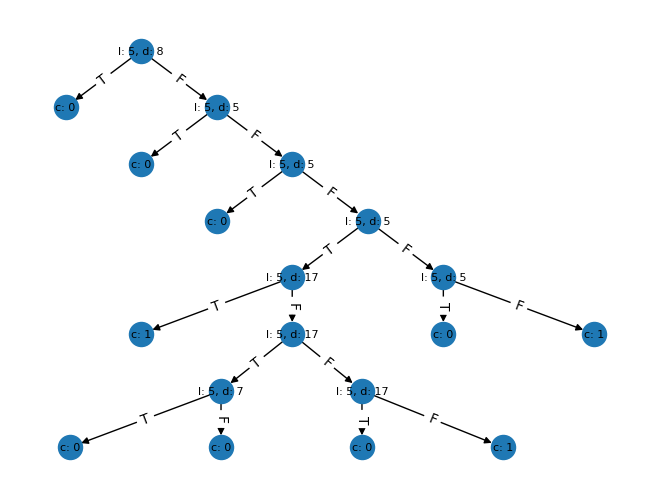

predicted : 0, real: 0
predicted : 0, real: 0
predicted : 1, real: 0
predicted : 1, real: 0
predicted : 1, real: 0
predicted : 1, real: 0
predicted : 1, real: 0
predicted : 1, real: 0
predicted : 0, real: 0
predicted : 1, real: 0
predicted : 0, real: 0
predicted : 0, real: 0
predicted : 0, real: 1
predicted : 1, real: 1
predicted : 0, real: 1
predicted : 0, real: 1
predicted : 1, real: 1
predicted : 1, real: 1
predicted : 1, real: 1
predicted : 1, real: 1
Accuracy: 0.5


In [363]:
df = parse_dataset(DATASET_PATH)


# keep only the first 100 of class 0 and 1
df = df[df["y"].isin(["0", "1"])].groupby("y").head(50)
df = df.reset_index(drop=True)


# split dataset into train and test
train = df.sample(frac=0.8)
test = df.drop(train.index)


# fit tree
T = Fit_Tree(None, train["s"].values, train["y"].values)

# show tree
plot_tree(T)
save_tree(T, "tree.png")

# predict
for v, row in test.iterrows():
    x = row["s"]
    y = row["y"]
    print(f"predicted : {Predict_Sample(T, x, x[0][0])}, real: {y}")

# evaluate
correct = 0
for v, row in test.iterrows():
    x = row["s"]
    y = row["y"]
    if Predict_Sample(T, x, x[0][0]) == y:
        correct += 1
print(f"Accuracy: {correct / len(test)}")

In [364]:
interations = 100
avg_accuracy = 0
for i in range(interations):
    train = df.sample(frac=0.8)
    test = df.drop(train.index)
    T = Fit_Tree(None, train["s"].values, train["y"].values)
    correct = 0
    for v, row in test.iterrows():
        x = row["s"]
        y = row["y"]
        if Predict_Sample(T, x, x[0][0]) == y:
            correct += 1
    avg_accuracy += correct / len(test)
    print(f"Accuracy: {correct / len(test)}")


print(f"Average accuracy: {avg_accuracy / interations}")

Accuracy: 0.55
current dataset:
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 0
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 0
yf: []
yt: ['1', '0', '1', '0']
Accuracy: 0.55
current dataset:
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 0
[(7, '5', 1)] -> 0
yf: []
yt: ['1', '0', '0']
Accuracy: 0.55
Accuracy: 0.55
current dataset:
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 0
[(7, '5', 1)] -> 0
yf: []
yt: ['1', '0', '0']
Accuracy: 0.45
current dataset:
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 0
[(7, '5', 1)] -> 0
yf: []
yt: ['1', '1', '0', '0']
Accuracy: 0.7
Accuracy: 0.65
Accuracy: 0.55
Accuracy: 0.45
Accuracy: 0.6
current dataset:
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 0
[(7, '5', 1)] -> 0
yf: []
yt: ['1', '0', '0']
Accuracy: 0.55
Accuracy: 0.55
Accuracy: 0.55
current dataset:
[(5, '5', 1)] -> 1
[(5, '5', 1)] -> 1
[(5, '5', 1)] -> 0
[(5, '5', 1)] -> 1
yf: []
yt: ['1', '1', '0', '1']
current dataset:
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 1
[(7, '5', 1)] -> 0
[(7, '5', 1)] -> 